In [56]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider

from scipy.signal import savgol_filter

# import raw data to MySQL

In [57]:
#load data from folder
ds = read_mpr.mpr_pandas('raw_data')

In [58]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/*.mpr') 
datafilespath = [os.path.splitext(val)[0] for val in [os.path.basename(x) for x in datafilespath]]

In [59]:
ds[3]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle
0,23,0,141180.533463,-1.855859e-10,-1.855859e-10,0.000000,2.097619,115,-1.855859e-10,0
1,23,0,141185.533464,0.000000e+00,-1.855859e-10,0.000000,2.094193,115,-1.855859e-10,0
2,7,0,141190.597464,0.000000e+00,-1.855859e-10,-0.020000,2.073522,117,-1.855859e-10,0
3,33,1,141190.599464,-1.112816e-08,-1.131375e-08,-0.020000,2.073010,117,-1.131375e-08,0
4,1,1,141195.599465,-2.781651e-05,-2.782783e-05,-0.020000,2.032771,117,-2.782783e-05,0
...,...,...,...,...,...,...,...,...,...,...
20206,18,1,242192.027999,-9.257834e-07,-3.127904e-01,-0.000051,-0.000349,117,-3.127904e-01,0
20207,18,1,242197.028000,-9.243815e-07,-3.127913e-01,-0.000051,-0.000388,117,-3.127913e-01,0
20208,18,1,242202.028000,-9.235472e-07,-3.127922e-01,-0.000051,-0.000349,117,-3.127922e-01,0
20209,18,1,242207.028001,-9.231514e-07,-3.127932e-01,-0.000051,-0.000427,117,-3.127932e-01,0


In [5]:
##struction 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        ds[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')


connection succeed
table cell_configuration created
table step01_geis of Cell001 created
table step02_gcpl of Cell001 created
table step03_geis of Cell001 created
table step04_gcpl of Cell001 created
table step01_geis of Cell002 created
table step02_gcpl of Cell002 created
table step03_geis of Cell002 created
table step04_gcpl of Cell002 created
table step01_geis of Cell003 created
table step02_gcpl of Cell003 created
table step03_geis of Cell003 created
table step04_gcpl of Cell003 created
table step01_geis of Cell004 created
table step02_gcpl of Cell004 created
table step03_geis of Cell004 created
table step04_gcpl of Cell004 created
table step01_geis of Cell005 created
table step02_gcpl of Cell005 created
table step03_geis of Cell005 created
table step04_gcpl of Cell005 created
table step01_geis of Cell006 created
table step02_gcpl of Cell006 created
table step03_geis of Cell006 created
table step04_gcpl of Cell006 created
table step01_geis of Cell007 created
table step02_gcpl of Ce

In [ ]:
#struction 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([ds[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data.to_sql('geis', engine, if_exists='fail',index=False)
    print('geis data of '+Cell_ID[i]+ ' loaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([ds[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data.to_sql('gcpl', engine, if_exists='fail',index=False)    
    print('gcpl data of '+Cell_ID[i]+ ' loaded')    

        
print('All data loaded')


# Savitzky-Golay filter

In [6]:
# query data from MySQL
##cell001,gcpl
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)

sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step02_gcpl'
cursor = Connection.cursor()
cursor.execute(sql)

charge = cursor.fetchall()

sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step04_gcpl'
cursor.execute(sql)

discharge = cursor.fetchall()

<IPython.core.display.Javascript object>


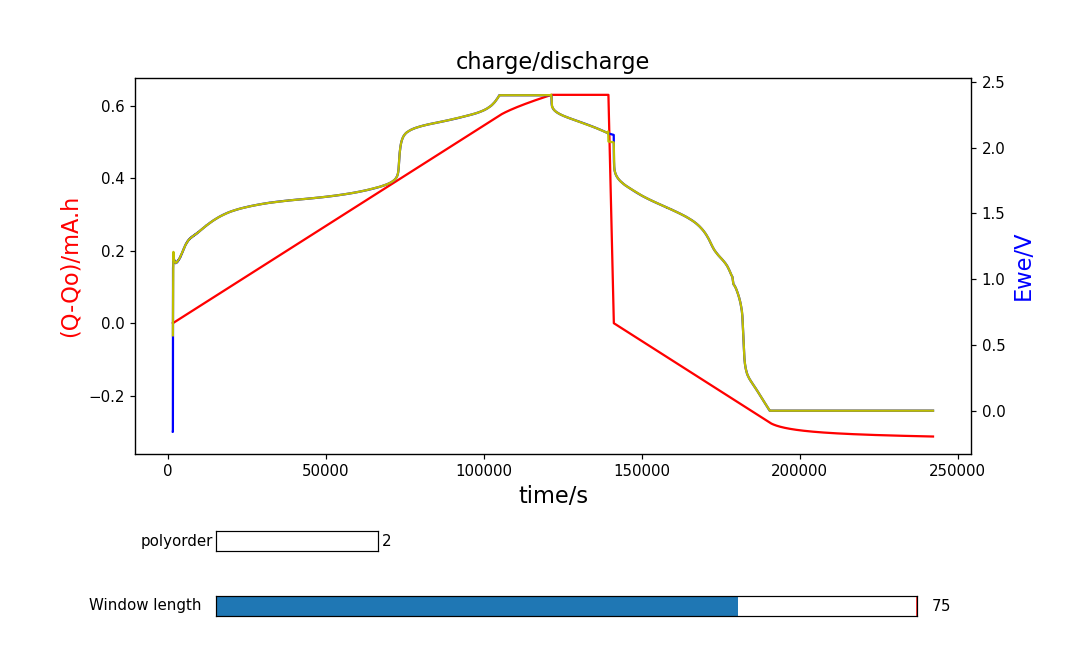

In [64]:
curve=np.concatenate((charge,discharge))
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red")
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(curve[:,2], curve[:,1],"b")
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)

p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],9,3), "y")

## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 99,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polyorder', valmin = 2,valmax = 9,valinit = 2,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()
